### Importing packages

In [4]:
import numpy as np
import pandas as pd
import nltk
import re

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import brown, gutenberg
from nltk.corpus import stopwords

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, LSTM
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping


nltk.download('brown')
nltk.download('gutenberg')
nltk.download('universal_tagset')
nltk.download('stopwords')

%matplotlib_inline

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
UsageError: Line magic function `%matplotlib_inline` not found.


In [2]:
brownCorpusSentences = brown.tagged_sents(tagset='universal')

In [7]:
# Sample sentence
print(brownCorpusSentences[0])
print("\n\nTotal number of sentences: {}".format(len(brownCorpusSentences)))

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Total number of sentences: 57340


### Creation of dataframe

* We create a dataframe with 2 data fields namely Sentence and POS Tagged which holds the sentences from Brown Corpus and the corresponding POS Tags 
* We perform the following operations:
    * Convert all words to lower case
    * Remove stop words
    * Remove punctuation marks

In [17]:
stop_words = set(stopwords.words('english'))

In [39]:
# Split the dataset into X and Y where X is the input sentence and Y refers to the POS tagged for each word of input X
inputSentence = []
posTaggedOutput = []
noOfSentences = len(brownCorpusSentences)
for i in range(noOfSentences):
    sentence = brownCorpusSentences[i]
    word = []
    tag = []
    for words in sentence:
        # convert all words to lower case and remove punctuation
        words_sentence = re.sub(r'[^\w\s]', '', str(words[0]).lower().strip())
        # Remove stop words
#         if words_sentence and words_sentence not in stop_words:
        word.append(words_sentence)
        tag.append(words[1])
    
    inputSentence.append(word)
    posTaggedOutput.append(tag)
    
df = pd.DataFrame()
df['Sentence'] = inputSentence
df['POS Tagged'] = posTaggedOutput

In [40]:
df

,Sentence,POS Tagged
0,"[the, fulton, county, grand, jury, said, frida...","[DET, NOUN, NOUN, ADJ, NOUN, VERB, NOUN, DET, ..."
1,"[the, jury, further, said, in, termend, presen...","[DET, NOUN, ADV, VERB, ADP, NOUN, NOUN, ADP, D..."
2,"[the, septemberoctober, term, jury, had, been,...","[DET, NOUN, NOUN, NOUN, VERB, VERB, VERB, ADP,..."
3,"[, only, a, relative, handful, of, such, repor...","[., ADV, DET, ADJ, NOUN, ADP, ADJ, NOUN, VERB,..."
4,"[the, jury, said, it, did, find, that, many, o...","[DET, NOUN, VERB, PRON, VERB, VERB, ADP, ADJ, ..."
...,...,...
57335,"[s, j, perelman]","[NOUN, NOUN, NOUN]"
57336,"[revulsion, in, the, desert]","[NOUN, ADP, DET, NOUN]"
57337,"[the, doors, of, the, d, train, slid, shut, , ...","[DET, NOUN, ADP, DET, NOUN, NOUN, VERB, VERB, ..."
57338,"[she, was, a, living, doll, and, no, mistake, ...","[PRON, VERB, DET, VERB, NOUN, CONJ, DET, NOUN,..."


In [41]:
df.iloc[0]['Sentence']

['the',
 'fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'an',
 'investigation',
 'of',
 'atlantas',
 'recent',
 'primary',
 'election',
 'produced',
 '',
 'no',
 'evidence',
 '',
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '']

In [42]:
df.iloc[0]['POS Tagged']

['DET',
 'NOUN',
 'NOUN',
 'ADJ',
 'NOUN',
 'VERB',
 'NOUN',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADJ',
 'NOUN',
 'NOUN',
 'VERB',
 '.',
 'DET',
 'NOUN',
 '.',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'NOUN',
 '.']

### Vectorize Words

* To create word embeddings or one hot encoding, we need to convert words to numbers
* Since the length of each sentence would be different, and that is not acceptable while feeding as input to the neural networks model, we must ensure all sentences are of same length and this is done by padding shorter sentences

In [43]:
# Get the vocabulary size and No of unique POS tags
vocabularySize = len(set([word for sentence in df['Sentence'] for word in sentence]))
noOfTags   = len(set([tags for sentence in df['POS Tagged'] for tags in sentence]))
print("Total no of unique words in all the sentences combined: ", vocabularySize)
print("Total no of unique tags: ", noOfTags)


# Tokenize the input and tags
inputTokenizer = Tokenizer()
inputTokenizer.fit_on_texts(inputSentence)
X_encoded = inputTokenizer.texts_to_sequences(inputSentence)

tagTokenizer = Tokenizer()
tagTokenizer.fit_on_texts(posTaggedOutput)
Y_encoded = tagTokenizer.texts_to_sequences(posTaggedOutput)

print("\nInput sentence: {}".format(inputSentence[0]))
print("Corresponding tokenized sentence: {}".format(X_encoded[0]))

print("\nPOS Tagged Output for above sentence: {}".format(posTaggedOutput[0]))
print("Corresponding POS Tagged tokenized output: {}".format(Y_encoded[0]))

Total no of unique words in all the sentences combined:  48018
Total no of unique tags:  12

Input sentence: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlantas', 'recent', 'primary', 'election', 'produced', '', 'no', 'evidence', '', 'that', 'any', 'irregularities', 'took', 'place', '']
Corresponding tokenized sentence: [2, 5437, 643, 2297, 1634, 55, 1840, 30, 2180, 3, 14182, 543, 1121, 1399, 1190, 1, 50, 464, 1, 8, 75, 9172, 203, 161, 1]

POS Tagged Output for above sentence: ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
Corresponding POS Tagged tokenized output: [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]


In [44]:
# Pad & Truncate Sequences
# Sentences whose length is greater than 200 will be truncated
# Sentences whose length is less than 200 will be appended with zeros
X = pad_sequences(X_encoded, maxlen = 200, padding = 'post', truncating = 'post')
Y = pad_sequences(Y_encoded, maxlen = 200, padding = 'post', truncating = 'post')

print("\nInput sentence: ", inputSentence[0])
print("Corresponding padded sentence: ", X[0])

print("\nPOS Tagged Output for above sentence: ", posTaggedOutput[0])
print("Corresponding POS Tagged padded output: ", Y[0])


Input sentence:  ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'atlantas', 'recent', 'primary', 'election', 'produced', '', 'no', 'evidence', '', 'that', 'any', 'irregularities', 'took', 'place', '']
Corresponding padded sentence:  [    2  5437   643  2297  1634    55  1840    30  2180     3 14182   543
  1121  1399  1190     1    50   464     1     8    75  9172   203   161
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0    

### One Hot Encoding

In [45]:
# Converting Y to one-hot encoding structure
# There are 57350 sentences and 12 different tags in total and each TAG is vectorized to be represented in 200 dimensions
unique_POSTags = (set([tags for sentence in df['POS Tagged'] for tags in sentence]))
Y = to_categorical(Y)
print("Y shape: ", Y.shape)
print("Unique POS Tags: ", unique_POSTags)

Y shape:  (57340, 200, 13)
Unique POS Tags:  {'X', 'NOUN', 'CONJ', 'ADV', '.', 'ADJ', 'NUM', 'PRT', 'DET', 'VERB', 'ADP', 'PRON'}


### Train-Validation-Test Split

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)
print("Training set X: ", X_train.shape)
print("Training set Y: ", Y_train.shape)
print("Validation set X: ", X_val.shape)
print("Validation set Y: ", Y_val.shape)
print("Test set X: ", X_test.shape)
print("Test set Y: ", Y_test.shape)

Training set X:  (41284, 200)
Training set Y:  (41284, 200, 13)
Validation set X:  (10322, 200)
Validation set Y:  (10322, 200, 13)
Test set X:  (5734, 200)
Test set Y:  (5734, 200, 13)


### Word Embeddings using GloVe Model

* We are using GloVe Model (pre-trained model) with 300-D (dimensions)

In [47]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('..\GloVe\glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {} word vectors.' .format(len(embeddings_index)))

Loaded 400001 word vectors.


In [48]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabularySize+1, 300))
for word, i in inputTokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print("Embedding Matrix: {}".format(embedding_matrix.shape))

Embedding Matrix: (48019, 300)


### LSTM with trainable GloVe embeddings

In [53]:
LSTM_model = Sequential()

# Embedding layer
LSTM_model.add(Embedding(input_dim    =  vocabularySize+1,       # vocabulary size - number of unique words in data
                        output_dim    =  300,                    # length of vector with which each word is represented
                        input_length  =  200,                    # length of input sequence
                        weights       = [embedding_matrix],      # word embedding matrix
                        trainable     =  True                    # True - update the embeddings while training
))

# LSTM layer with 32 & 64 cells
LSTM_model.add(LSTM(32, return_sequences=True))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(64, return_sequences=True))

# Time distributed (output at each sequence) layer
LSTM_model.add(TimeDistributed(Dense(13, activation='softmax')))

In [54]:
LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          14405700  
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 32)           42624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 64)           24832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 200, 13)           845       
Total params: 14,474,001
Trainable params: 14,474,001
Non-trainable params: 0
_________________________________________________________________


In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
LSTM_training = LSTM_model.fit(X_train, Y_train, 
                             batch_size = 128, 
                             epochs=25, 
                             validation_data=(X_val, Y_val),
                             callbacks = [es]
                            )

Epoch 1/25
323/323 [==============================] - 237s 669ms/step - loss: 0.3626 - acc: 0.9207 - val_loss: 0.0324 - val_acc: 0.9910
Epoch 2/25
323/323 [==============================] - 229s 709ms/step - loss: 0.0295 - acc: 0.9915 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 3/25
323/323 [==============================] - 233s 723ms/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0135 - val_acc: 0.9955
Epoch 4/25
323/323 [==============================] - 239s 741ms/step - loss: 0.0138 - acc: 0.9956 - val_loss: 0.0123 - val_acc: 0.9958
Epoch 5/25
323/323 [==============================] - 225s 696ms/step - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0115 - val_acc: 0.9961
Epoch 6/25
323/323 [==============================] - 222s 687ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0112 - val_acc: 0.9961
Epoch 7/25
323/323 [==============================] - 193s 597ms/step - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0109 - val_acc: 0.9962
Epoch 8/25
323/323 [============================

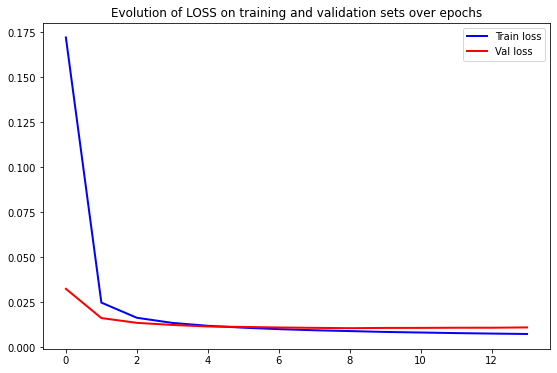

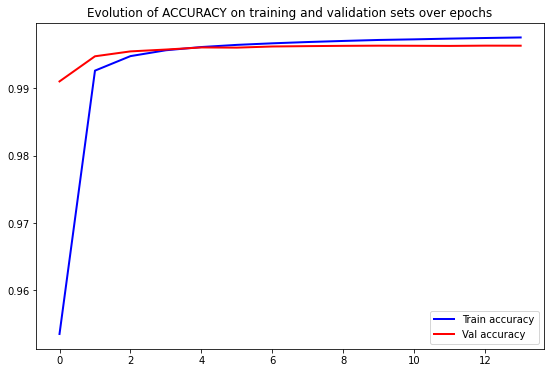

In [56]:
# Plotting Training Vs Validation Graphs

epoch_loss = LSTM_training.history['loss']
epoch_val_loss = LSTM_training.history['val_loss']
epoch_acc = LSTM_training.history['acc']
epoch_val_acc = LSTM_training.history['val_acc']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train loss')
plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val loss')
plt.title('Evolution of LOSS on training and validation sets over epochs')
plt.legend(loc='best')

plt.figure(figsize=(20,6))
plt.subplot(1,2,2)
plt.plot(range(0, len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train accuracy')
plt.plot(range(0, len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val accuracy')
plt.title('Evolution of ACCURACY on training and validation sets over epochs')
plt.legend(loc='best')


In [57]:
loss, accuracy = LSTM_model.evaluate(X_test, Y_test, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

180/180 [==============================] - 13s 74ms/step - loss: 0.0107 - acc: 0.9964
Test Loss: 0.010706603527069092,
Test Accuracy: 0.9963864684104919


### Prediction for a sample sentence

In [63]:
sent = ["where are they going on sunday?"]
sent_encoded = inputTokenizer.texts_to_sequences(sent)
X_sent = pad_sequences(sent_encoded, maxlen = 200, padding = 'post', truncating = 'post')

output_weights = LSTM_model.predict(X_sent[0])
print("The input is: {}".format(sent[0]))
i = 0
for x in output_weights:
    pos = np.argmax(x)
    for word, index in tagTokenizer.word_index.items():
        if(pos == index):
            print('('  + word + ')')
    i += 1

The input is: where are they going on sunday?
(adv)
(verb)
(pron)
(verb)
(adp)
(noun)


### RNN with trainable GloVe embeddings

In [67]:
RNN_model = Sequential()

# Embedding layer
RNN_model.add(Embedding(input_dim     =  vocabularySize+1,         # vocabulary size - number of unique words in data
                        output_dim    =  300,                    # length of vector with which each word is represented
                        input_length  =  200,                    # length of input sequence
                        weights       = [embedding_matrix],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# RNN layer with 64 RNN cells
RNN_model.add(SimpleRNN(64, return_sequences=True))

# Time distributed (output at each sequence) layer
RNN_model.add(TimeDistributed(Dense(13, activation='softmax')))

In [68]:
RNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])
RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          14405700  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200, 64)           23360     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 200, 13)           845       
Total params: 14,429,905
Trainable params: 14,429,905
Non-trainable params: 0
_________________________________________________________________


In [69]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
RNN_training = RNN_model.fit(X_train, Y_train, 
                             batch_size=64, 
                             epochs=10, 
                             validation_data=(X_val, Y_val),
                             callbacks = [es]
                            )

Epoch 1/10
646/646 [==============================] - 131s 201ms/step - loss: 0.1814 - acc: 0.9578 - val_loss: 0.0148 - val_acc: 0.9949
Epoch 2/10
646/646 [==============================] - 129s 200ms/step - loss: 0.0129 - acc: 0.9955 - val_loss: 0.0121 - val_acc: 0.9958
Epoch 3/10
646/646 [==============================] - 218s 338ms/step - loss: 0.0101 - acc: 0.9965 - val_loss: 0.0109 - val_acc: 0.9962
Epoch 4/10
646/646 [==============================] - 221s 342ms/step - loss: 0.0089 - acc: 0.9969 - val_loss: 0.0108 - val_acc: 0.9962
Epoch 5/10
646/646 [==============================] - 144s 222ms/step - loss: 0.0079 - acc: 0.9973 - val_loss: 0.0104 - val_acc: 0.9963
Epoch 6/10
646/646 [==============================] - 145s 225ms/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.0103 - val_acc: 0.9964
Epoch 7/10
646/646 [==============================] - 145s 225ms/step - loss: 0.0066 - acc: 0.9978 - val_loss: 0.0104 - val_acc: 0.9963
Epoch 8/10
646/646 [============================

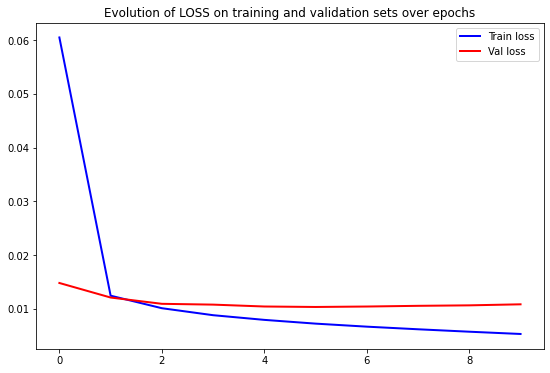

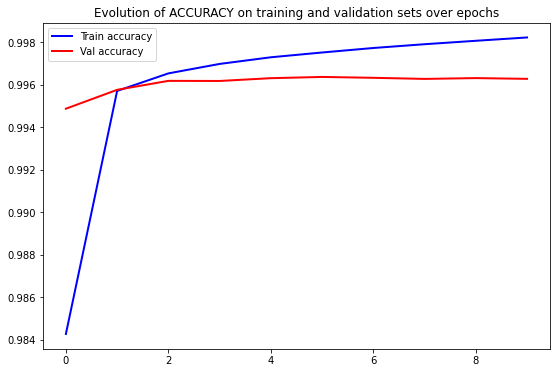

In [73]:
# Plotting Training Vs Validation Graphs

epoch_loss = RNN_training.history['loss']
epoch_val_loss = RNN_training.history['val_loss']
epoch_acc = RNN_training.history['acc']
epoch_val_acc = RNN_training.history['val_acc']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train loss')
plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val loss')
plt.title('Evolution of LOSS on training and validation sets over epochs')
plt.legend(loc='best')

plt.figure(figsize=(20,6))
plt.subplot(1,2,2)
plt.plot(range(0, len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train accuracy')
plt.plot(range(0, len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val accuracy')
plt.title('Evolution of ACCURACY on training and validation sets over epochs')
plt.legend(loc='best')


In [74]:
loss, accuracy = RNN_model.evaluate(X_test, Y_test, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

180/180 [==============================] - 5s 28ms/step - loss: 0.0107 - acc: 0.9963
Test Loss: 0.010748816654086113,
Test Accuracy: 0.9963158369064331


### Prediction for a sample sentence

In [75]:
sent = ["where are they going on sunday?"]
sent_encoded = inputTokenizer.texts_to_sequences(sent)
X_sent = pad_sequences(sent_encoded, maxlen = 200, padding = 'post', truncating = 'post')

output_weights = RNN_model.predict(X_sent[0])

for x in output_weights:
    pos = np.argmax(x)
    for word, index in tagTokenizer.word_index.items():
        if(pos == index):
            print(word)

adv
verb
pron
verb
adp
noun


In [34]:
nltk.download('indian')
nltk.corpus.indian.tagged_words()

[nltk_data] Downloading package indian to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\indian.zip.


[('মহিষের', 'NN'), ('সন্তান', 'NN'), (':', 'SYM'), ...]